## Intro to Machine Learning and Deep learning

The goal of this assignment is to familiarize with the linear regression methods:

1. Repeat the previous jupyter notebook using the diabetes database
   ```python
   ...
   import mean_squared_error, r2_score
   # load the diabetes dataset
   diabetes_X, diabetes_Y = datasets.load(return_X_y=True)
   ```
2. Find labels and use them to build a linear classifier
3. Generate the $\bm{\tilde{X}}$ augmented samples and the $\bm{Y}$ labels and build the classifier.
4. Use a threshold to decide what are the labels in the data.
5. Then use the following $\verb+linear_model+$ package from $\verb+sklearn+$:
    ```python
    from sklearn import linear_model
    ```
6. Fit the X and Y using the instruction:
   ```python
   # Create a linear regression
   object regr = linear_model.LinearRegression()
   # Train the model using the training sets
   regr.fit(diabetes_X_train, diabetes_Y_train)
   # Make predictions using the testing
   set diabetes_Y_pred = regr.predict(diabetes_X_test)
   ```
7. Finally, compare both methods and provide a discussion.
---

## Data set aquisition

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn import datasets
from sklearn.model_selection import train_test_split

Import the [_diabetes_ dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) from `sklearn` 

In [114]:
diabetes_X, diabetes_Y = datasets.load_diabetes(return_X_y=True) #,as_frame=True,scaled=False

we need to remap the feature dataset as a 2 dimentional numpy array

In [115]:

diabetes_Y = np.array([diabetes_Y]).T
diabetes_Y.shape

(442, 1)

observe that each row of the `diabetes_X` array is the data for one person, that is, one _observation_.

In [116]:
diabetes_X[1,:]

array([-0.00188202, -0.04464164, -0.05147406, -0.02632753, -0.00844872,
       -0.01916334,  0.07441156, -0.03949338, -0.06833155, -0.09220405])

Ok, so we're ready to begin. As our ML training recipe dictates, we need to partition our input data into training and testing datasets, for that purpose we'll be using the  `train_test_split(X,Y, train_size)` from the  `sklearn.model_selection` library.

In [117]:
diabetes_X_train, diabetes_X_test, diabetes_Y_train, diabetes_Y_test = train_test_split(diabetes_X, diabetes_Y, train_size=0.2)

((88, 10), (88, 1))

In order to label our training dataset, let us plot the feature dataset scattering

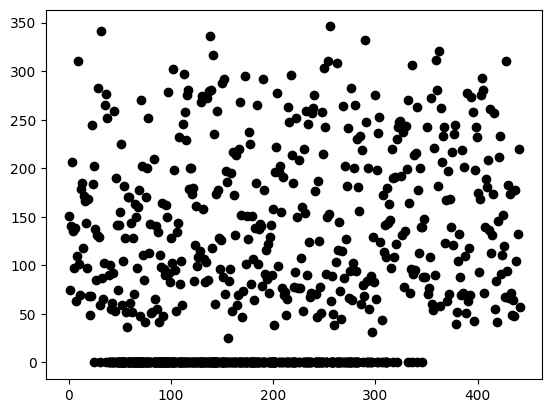

In [123]:
fig, ax = plt.subplots()
ax.plot(diabetes_Y, 'ok')
ax.plot(diabetes_Y,0*diabetes_Y, 'ok')

In [ ]:
diabetes_Y_train


array([[155.],
       [ 48.],
       [310.],
       [ 51.],
       [ 57.],
       [233.],
       [135.],
       [ 60.],
       [123.],
       [ 94.],
       [200.],
       [246.],
       [156.],
       [ 78.],
       [ 53.],
       [174.],
       [ 60.],
       [ 97.],
       [ 96.],
       [101.],
       [243.],
       [200.],
       [182.],
       [ 83.],
       [270.],
       [ 53.],
       [310.],
       [ 90.],
       [ 65.],
       [277.],
       [ 58.],
       [232.],
       [160.],
       [ 77.],
       [ 50.],
       [ 78.],
       [275.],
       [233.],
       [132.],
       [ 78.],
       [128.],
       [ 85.],
       [ 49.],
       [113.],
       [258.],
       [118.],
       [ 42.],
       [ 59.],
       [237.],
       [173.],
       [ 93.],
       [ 68.],
       [210.],
       [ 63.],
       [242.],
       [273.],
       [109.],
       [200.],
       [248.],
       [317.],
       [ 98.],
       [ 59.],
       [192.],
       [127.],
       [142.],
       [ 88.],
       [11

In [ ]:
diabetes_X_train

array([[ 3.44433680e-02, -4.46416365e-02, -7.28376621e-03,
         1.49866836e-02, -4.42234984e-02, -3.73259505e-02,
        -2.90282981e-03, -3.94933829e-02, -2.13953093e-02,
         7.20651633e-03],
       [-5.63700933e-02, -4.46416365e-02, -7.41081148e-02,
        -5.04274850e-02, -2.49601584e-02, -4.70335528e-02,
         9.28197531e-02, -7.63945038e-02, -6.11757990e-02,
        -4.66408736e-02],
       [ 4.89735218e-02,  5.06801187e-02,  8.86415084e-02,
         8.72865541e-02,  3.55817674e-02,  2.15459603e-02,
        -2.49926566e-02,  3.43088589e-02,  6.60506666e-02,
         1.31469724e-01],
       [-5.51455498e-03,  5.06801187e-02,  1.33873038e-03,
        -8.48559947e-02, -1.12006298e-02, -1.66581521e-02,
         4.86400995e-02, -3.94933829e-02, -4.11761669e-02,
        -8.80619427e-02],
       [-4.54724779e-02, -4.46416365e-02, -7.30303027e-02,
        -8.14131438e-02,  8.37401174e-02,  2.78089295e-02,
         1.73815785e-01, -3.94933829e-02, -4.22151394e-03,
         3.

In [ ]:
diabetes_Y_train


array([[155.],
       [ 48.],
       [310.],
       [ 51.],
       [ 57.],
       [233.],
       [135.],
       [ 60.],
       [123.],
       [ 94.],
       [200.],
       [246.],
       [156.],
       [ 78.],
       [ 53.],
       [174.],
       [ 60.],
       [ 97.],
       [ 96.],
       [101.],
       [243.],
       [200.],
       [182.],
       [ 83.],
       [270.],
       [ 53.],
       [310.],
       [ 90.],
       [ 65.],
       [277.],
       [ 58.],
       [232.],
       [160.],
       [ 77.],
       [ 50.],
       [ 78.],
       [275.],
       [233.],
       [132.],
       [ 78.],
       [128.],
       [ 85.],
       [ 49.],
       [113.],
       [258.],
       [118.],
       [ 42.],
       [ 59.],
       [237.],
       [173.],
       [ 93.],
       [ 68.],
       [210.],
       [ 63.],
       [242.],
       [273.],
       [109.],
       [200.],
       [248.],
       [317.],
       [ 98.],
       [ 59.],
       [192.],
       [127.],
       [142.],
       [ 88.],
       [11

Some resources:
- https://tdgunes.com/COMP6246-2019Fall/cw1_solution/index.html
- http://www.devdoc.net/python/sklearn-0.18/auto_examples/linear_model/plot_ols_3d.html#sphx-glr-auto-examples-linear-model-plot-ols-3d-py
- http://www.devdoc.net/python/sklearn-0.18/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
- http://www.devdoc.net/python/sklearn-0.18/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py